In [1]:
import pandas as pd
from glob import glob
import pybedtools
from collections import defaultdict

In [2]:
figures_directory = '/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/Figures/RBFOX2_motif_permutations_union/'

# shuffles of eCLIP peaks -- fraction overlapped by STAMP peaks

# Load STAMP peaks

# load shuffled stamp peaks

In [3]:
shuffled_peak_with_sequence_filepaths = glob('/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/9.4_shuffled_union_peaks/*/*with_sequence.bed')



In [4]:
len(shuffled_peak_with_sequence_filepaths)

100

# Compare permuted fraction for motif

In [6]:
permuted_fractions = pd.read_csv('9.4_shuffled_union_peaks/FOX_cleaned_motif_presence_in_union_shuffles.tsv', sep='\t', index_col=0)
permuted_fractions_cleaned = pd.read_csv('9.4_shuffled_union_peaks/FOX_cleaned_motif_presence_in_union_shuffles.tsv', sep='\t', index_col=0)

permuted_fractions = pd.concat([permuted_fractions, permuted_fractions_cleaned], axis=1)

In [7]:
peak_set_to_motif_presence = defaultdict(lambda:[])
for l, v in permuted_fractions.loc['TGCATG'].items():
    #print(l, v)
    main_category = l.split('_shuffle')[0]
    peak_set_to_motif_presence[main_category].append(v)

In [8]:
peak_set_to_motif_presence

defaultdict(<function __main__.<lambda>()>,
            {'unioned_cleaned_peaks.bed': [0.046444384205295,
              0.0402096322399927,
              0.0448179271708683,
              0.0423782416192283,
              0.0409325020330712,
              0.044004698653655,
              0.0407517845848016,
              0.0437336224812505,
              0.0428300352399024,
              0.042016806722689,
              0.0453600795156772,
              0.0438239812053853,
              0.0416553718261498,
              0.0406614258606668,
              0.0460829493087557,
              0.0438239812053853,
              0.0465347429294298,
              0.0445468509984639,
              0.0419264479985542,
              0.0447275684467335,
              0.0421071654468238,
              0.0443661335501942,
              0.0445468509984639,
              0.0457215144122165,
              0.0401192735158579,
              0.0431011114123068,
              0.0434625463088461,
            

### Find actual fraction with motif

In [11]:
from pyfaidx import Fasta
import re
fasta = '/projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/fasta/genome.fa'
FA = Fasta(fasta, rebuild=False)
import math

def get_sequence(r): 
    chrom = str(r.chrom)
    start = r.start
    end = r.end
    strand = r.strand
    
    sequence = FA[chrom][start:end].seq
    sequence = sequence.upper()
        
    return sequence

def get_extended_sequence(r): 
    chrom = str(r.chrom)
    
    midpoint = r.start + (int((r.end - r.start)/2))
    start = midpoint - 400
    end = midpoint + 400
    strand = r.strand
    
    sequence = FA[chrom][start:end].seq
    sequence = sequence.upper()
        
    return sequence

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
def reverse_complement(seq):
    return "".join(complement.get(base, base) for base in reversed(seq))

def reverse(seq):
    return seq[::-1]

def motif_present(sequence, motif, strand):
    if strand == '+':
        return motif in sequence
    elif strand == '-':
        return reverse_complement(motif) in sequence

def motif_distance_from_center(sequence, motif, strand):
    #print(sequence)
    if strand == '+':
        search_term = motif
    elif strand == '-':
        search_term = reverse_complement(motif)
    else:
        search_term = motif
        
    if search_term in sequence:
        closest_position_in_first_half = 1000
        closest_position_in_second_half = 1000
        
        midpoint = math.ceil(len(sequence)/2)
        #print('\tmidpoint is {}'.format(midpoint))
        start_of_second_half = midpoint-len(motif)

        sequence_first_half = sequence[0:midpoint]
        sequence_second_half = sequence[start_of_second_half:]

        #print('\tSplit:', sequence_first_half, sequence_second_half)
        if search_term in sequence_first_half:
            flipped_sequence = reverse(sequence_first_half)
            flipped_search_term = reverse(search_term)
            
            #print('searching for {} in {}'.format(flipped_search_term, flipped_sequence))
            closest_position_in_first_half = - flipped_sequence.index(flipped_search_term) - math.floor(len(motif)/2)
            
        if search_term in sequence_second_half:
            closest_position_in_second_half = sequence_second_half.index(search_term) - math.floor(len(motif)/2)

        #print([closest_position_in_first_half, closest_position_in_second_half])
        if min(abs(closest_position_in_second_half), abs(closest_position_in_first_half)) == abs(closest_position_in_second_half):
            return closest_position_in_second_half
        else:
            return closest_position_in_first_half
    else:
        return None
    
motifs = ['TGCATG', 'GAATG', 'GTTTG', 'GTGTG', 'GTATG', 'GCTTG', 'GCCTG']

def add_sequence_presences(r, window_size=70):
    extended_sequence = r['extended_sequence(+)']
    strand = r.strand

    distance_tgcatg = motif_distance_from_center(extended_sequence, 'TGCATG', strand)
    distance_gcatg = motif_distance_from_center(extended_sequence, 'GCATG', strand)
    distance_gaatg = motif_distance_from_center(extended_sequence, 'TGAATG', strand)
    distance_gtttg = motif_distance_from_center(extended_sequence, 'TGAATG', strand)
    distance_gtgtg = motif_distance_from_center(extended_sequence, 'TGTGTG', strand)
    distance_gtatg = motif_distance_from_center(extended_sequence, 'TGTATG', strand)
    distance_gcttg = motif_distance_from_center(extended_sequence, 'TGCTTG', strand)
    distance_gcctg = motif_distance_from_center(extended_sequence, 'TGCCTG', strand)


    sequence = r['sequence(+)']

    presence_map = {motif: motif_present(sequence, motif, strand) for motif in motifs}
    return presence_map.get(motifs[0]), presence_map.get(motifs[1]), presence_map.get(motifs[2]), presence_map.get(motifs[3]), presence_map.get(motifs[4]), presence_map.get(motifs[5]), presence_map.get(motifs[6]), distance_tgcatg, distance_gcatg,distance_gaatg,distance_gtttg,distance_gtgtg,distance_gtatg,distance_gcttg,distance_gcctg


def calculate_fractions(p_df):
    fractions_dict = {}
    counts_dict = {}
    
    for motif in motifs + ['any_motif']:
        motif_present_count = p_df[motif].sum()
        motif_present_fraction = motif_present_count/len(p_df)
        fractions_dict[motif] = motif_present_fraction
        counts_dict[motif] = motif_present_count
    
    return fractions_dict, counts_dict

In [22]:
peak_filepaths = sorted(glob('9.4_unioned_peaks/*.bed'))

stamp_file_dfs = {}

for peak_filepath in peak_filepaths:    
    print(peak_filepath)
    file_id = peak_filepath.split('/')[-1].split('.bed')[0]
    if 'SLBP' not in file_id:
        print('\t', file_id)
        stamp_file_dfs[file_id] = pd.read_csv(peak_filepath, sep='\t', 
                                              names=['chrom', 'start', 'end', 'enzyme', 'symbol', 'strand']
                                             )

9.4_unioned_peaks/unioned_cleaned_peaks.bed
	 unioned_cleaned_peaks


In [24]:
motifs = ['TGCATG', 'GAATG', 'GTTTG', 'GTGTG', 'GTATG', 'GCTTG', 'GCCTG']


In [25]:
from collections import defaultdict

actual_motif_fractions = defaultdict(lambda:{})
dfs_with_motif_info = {}
for label,df in stamp_file_dfs.items():
    print(label)
    print('\t', len(df))
    df['sequence(+)'] = df.apply(get_sequence, axis=1)
    df['extended_sequence(+)'] = df.apply(get_extended_sequence, axis=1)

    df[motifs[0]],df[motifs[1]],df[motifs[2]],df[motifs[3]],df[motifs[4]],df[motifs[5]],df[motifs[6]],df['TGCATG_dist_from_center'], df['GCATG_dist_from_center'],df['GAATG_dist_from_center'], df['GTTTG_dist_from_center'],df['GTGTG_dist_from_center'],df['GTATG_dist_from_center'], df['GCTTG_dist_from_center'],df['GCCTG_dist_from_center'] = zip(*df.apply(add_sequence_presences, axis=1))

    df['any_motif'] = df[[motifs[0], motifs[1], motifs[2], motifs[3], motifs[4], motifs[5], motifs[6]]].any(axis=1)
    dfs_with_motif_info[label] = df
    
    for motif in motifs + ['any_motif']:
        print('Checking {}'.format(motif))
        actual_motif_fractions[label][motif] = len(df[df[motif] == True])/len(df)

unioned_cleaned_peaks
	 11123
Checking TGCATG
Checking GAATG
Checking GTTTG
Checking GTGTG
Checking GTATG
Checking GCTTG
Checking GCCTG
Checking any_motif


In [29]:
# plot options
peak_union = ['unioned_cleaned_peaks.bed']

In [32]:
actual_motif_fractions['unioned_cleaned_peaks.bed'] = actual_motif_fractions['unioned_cleaned_peaks']

peak_union
	 /projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/Figures/RBFOX2_motif_permutations_union//stamp_peak_tgcatg_motif_permutation-peak_union
unioned_cleaned_peaks.bed 0.0


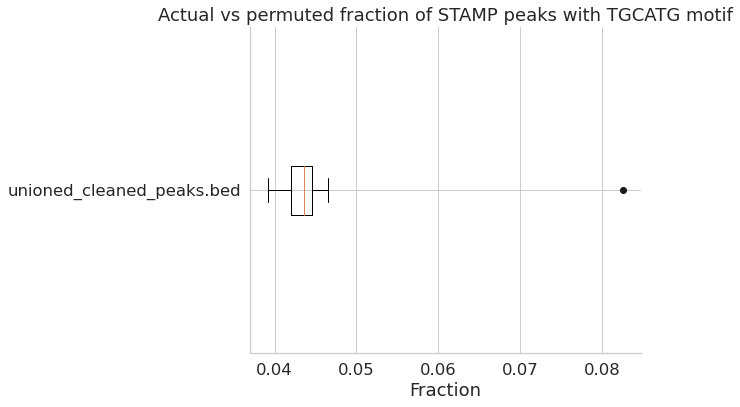

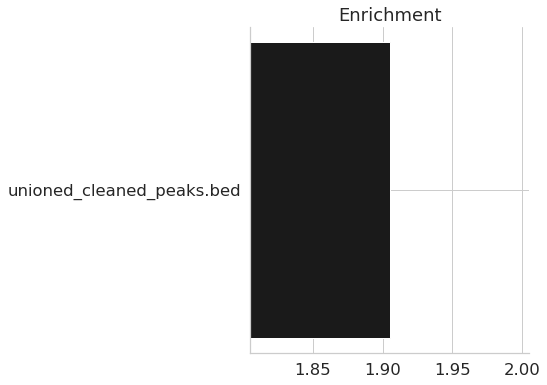

In [33]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

label_options = [peak_union]

title_base = 'stamp_peak_tgcatg_motif_permutation-'
title_options = ['peak_union']


for labels_subset, title_suffix in zip(label_options, title_options):
    print(title_suffix)
    
    for l in labels_subset:
        assert(l in peak_set_to_motif_presence.keys())


    # Plot boxplots
    plt.figure(figsize=(7, 6))

    a = plt.boxplot([peak_set_to_motif_presence.get(l) for l in labels_subset]
                    , vert=False, showfliers=False)

    range_array= [i+1 for i in range(len(labels_subset))]

    b = plt.scatter([actual_motif_fractions.get(l).get('TGCATG') for l in labels_subset], range_array, color='k')
    plt.xlabel("Fraction")
    plt.title("Actual vs permuted fraction of STAMP peaks with TGCATG motif")
    c = plt.yticks(range_array, labels_subset)

    filename = '{}/{}{}'.format(figures_directory, title_base, title_suffix)
    print('\t', filename)
    plt.savefig('{}-box.png'.format(filename), bbox_inches='tight')
    plt.savefig('{}-box.svg'.format(filename), bbox_inches='tight')


    # Plot enrichment

    tick_list = labels_subset

    motif_odds_ratios = {}
    for k in peak_set_to_motif_presence.keys():

        permuted_val = np.mean(peak_set_to_motif_presence.get(k))
        actual_val = actual_motif_fractions.get(k).get('TGCATG')
        
        num_exceeding_actual = [v for v in peak_set_to_motif_presence.get(k) if v > actual_val]
        pval = len(num_exceeding_actual)/len(peak_set_to_motif_presence.get(k))
        print(k, pval)
        motif_odds_ratios[k] = actual_val/permuted_val

    ordered_motif_ors = []
    for o in tick_list:
        ordered_motif_ors.append(motif_odds_ratios.get(o))

    min_odds_ratio = np.min(ordered_motif_ors)
    max_odds_ratio = np.max(ordered_motif_ors)
    
    plt.figure(figsize=(5, 6))
    plt.barh(tick_list, ordered_motif_ors, color='k')
    plt.xlim(min_odds_ratio-0.1,max_odds_ratio+0.1)
    plt.title("Enrichment")
    
    plt.savefig('{}-enrich.png'.format(filename), bbox_inches='tight')
    plt.savefig('{}-enrich.svg'.format(filename), bbox_inches='tight')

# Distance from center of GCATG motif

In [34]:
to_plot_together = {}


for experiment in to_plot_together_label:
    print(experiment)
    df = dfs_with_motif_info.get(experiment)
    df_with_dists = df[~df.TGCATG_dist_from_center.isna()]
    
    to_plot_together[experiment] = df_with_dists
        
    #c = plt.figure()
    #b = sns.distplot(df_with_dists.TGCATG_dist_from_center, bins=50)
    #a = plt.title('{} Distribution of Closest TGCATG motif distance from center'.format(experiment))

distance_columns = [c for c in list(df.columns[-9:]) if 'dist' in c]

for c in distance_columns:
    legend = []
    plt.figure(figsize=(14, 10))
    for label, df in to_plot_together.items():
        legend.append(label)
        plt.xlim(-350, 350)
        g = sns.distplot(df[c], hist=False, kde_kws=dict(linewidth=5))
    g.set(yticklabels=[])
    plt.legend(legend)
    motif_label = c.split('_')[0]
    plt.xlabel("Distance from peak center to closest instance of {}".format(motif_label))
    plt.ylabel("Density")
    plt.title("Distribution of distance to closest {} across peak sets".format(motif_label))
    #plt.savefig('/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/Figures/RBFOX2_motif_distance_to_center/{}_distance_to_center.png'.format(motif_label), bbox_inches='tight')
    #plt.savefig('/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/Figures/RBFOX2_motif_distance_to_center/{}_distance_to_center.svg'.format(motif_label),bbox_inches='tight')

    break

NameError: name 'to_plot_together_label' is not defined